# Make of a neural network with numpy

### Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

/tmp/ipykernel_10674/2080034654.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Using ndarrays as Tensors, adding the typing library to be more explicit and creating a new type "Func" which is a function taking a Tensor as argument and returning a Tensor

In [2]:
from numpy import ndarray as Tensor

from typing import (Dict, Tuple, Callable, 
                    Sequence, Iterator, NamedTuple)
Func = Callable[[Tensor], Tensor]

### Defining the Loss function to minimize

In [3]:
# Class constructiong a generic loss function

class Loss:
    def loss(self, predicted: Tensor, actual: Tensor) -> float:
        """ 
        Compute the loss between predictions and actual labels 
        """
        raise NotImplementedError

    def grad(self, predicted: Tensor, actual: Tensor) -> Tensor:
        """ 
        Compute the gradient for the backward pass 
        """
        raise NotImplementedError

# Mean square error loss

class MeanSquareError(Loss):
    def loss(self, predicted: Tensor, actual: Tensor) -> float:
        return np.sum((predicted - actual)**2) / len(actual)
    
    def grad(self, predicted: Tensor, actual: Tensor) -> Tensor:
        return (2 * (predicted - actual)) / len(actual)
    
# Binary cross entropy loss

class BinCrossEntropy(Loss):
    def loss(self, predicted: Tensor, actual: Tensor) -> float:
        return - ((np.sum(actual * np.log(predicted) + (1 - actual) * np.log(1 - predicted))) / len(actual))
    
    def grad(self, predicted: Tensor, actual: Tensor) -> Tensor:
        return - (((actual / predicted) - ((1 - actual) / (1 - predicted))) / len(actual))


### Constructring the different layers with classes

In [4]:
# Class constructing a generic layer

class Layer:
    def __init__(self) -> None:

        # Store the parameters values and gradients in dictionnaries
        self.params: Dict[str, Tensor] = {}
        self.grads: Dict[str, Tensor] = {}

    def forward(self, inputs: Tensor) -> Tensor:
        raise NotImplementedError

    def backward(self, grad: Tensor) -> Tensor:
        raise NotImplementedError


# Class constructing a linear layer of neurons

class Linear(Layer):
    """
    Inputs are of size (batch_size, input_size)
    Outputs are of size (batch_size, output_size)
    """
    def __init__(self, input_size: int, output_size: int, Seed: bool = False) -> None:
    
        # Inherit from base class Layer
        super().__init__()
        
        # Initialize the weights and bias with random values
        if Seed == True:
            np.random.seed(5)

        self.params["w"] = np.random.randn(input_size, output_size)
        self.params["b"] = np.random.randn(output_size)

    def forward(self, inputs: Tensor) -> Tensor:
        """
        inputs shape is (batch_size, input_size)
        """
        self.inputs = inputs

        # Compute the feed forward pass
        # (b,i) @ (i,o) + (1,o) = (b,o)
        return inputs @ self.params["w"] + self.params["b"]
        
         
    def backward(self, grad: Tensor) -> Tensor:
        """
        grad shape is (batch_size, output_size)
        """
        # Compute the gradient parameters for the layer
        # (i,b) @ (b,o) = (i,o)
        self.grads["w"] =  np.transpose(self.inputs) @ grad
        self.grads["b"] = grad #(b,o)
    
        # Compute the feed backward pass
        # (b,o) @ (o,i) = (b,i)
        return grad @ np.transpose(self.params["w"])


#Defining possible activation functions

def tanh(x: Tensor) -> Tensor:
    return np.tanh(x)

def tanh_prime(x: Tensor) -> Tensor:
    return 1 - (np.tanh(x))**2

def sigmoid(x: Tensor) -> Tensor:
    return 1/(1 + np.exp(-x))

def sigmoid_prime(x: Tensor) -> Tensor:
    return sigmoid(x)*(1 - sigmoid(x))


# Class constructing an activation layer

class Activation(Layer):
    """
    An activation layer just applies a function
    elementwise to its inputs
    """
    def __init__(self, f: Func, f_prime: Func) -> None:
        super().__init__()
        self.f = f
        self.f_prime = f_prime

    def forward(self, inputs: Tensor) -> Tensor:
        self.inputs = inputs
        return self.f(inputs)

    def backward(self, grad: Tensor) -> Tensor:
        return self.f_prime(self.inputs) * grad
    
    

### Class defining how to organize the data in series of batch

In [5]:
Batch = NamedTuple("Batch", [("inputs", Tensor), ("targets", Tensor)])
        
class BatchIterator:
    """ 
    Organize the data in batch that are shuffled at each epoch
    """
    def __init__(self, batch_size: int = 32, shuffle: bool = True) -> None:
        self.batch_size = batch_size
        self.shuffle = shuffle

    def __call__(self, inputs: Tensor, targets: Tensor) -> Iterator[Batch]:
        """ 
        Create batch iteratively and yields them one after the other
        """
        starts = np.arange(0, len(inputs), self.batch_size)
        if self.shuffle:
            np.random.shuffle(starts)

        for start in starts:
            end = start + self.batch_size
            batch_inputs = inputs[start:end]
            batch_targets = targets[start:end]
            yield Batch(batch_inputs, batch_targets)

### Class constructing the network, doing the full forward and backward pass and optimizing the parameters

In [6]:
class NeuralNet:
    def __init__(self, layers: Sequence[Layer], lr: float = 0.01) -> None:
        self.layers = layers
        # Learning rate
        self.lr = lr 
        
    def forward(self, inputs: Tensor) -> Tensor:
        """
        The forward pass takes the layers in order
        """
        for layer in self.layers:
            inputs = layer.forward(inputs)
        return inputs

    def backward(self, grad: Tensor) -> Tensor:
        """
        The backward pass is the other way around
        """
        for layer in reversed(self.layers):
            grad = layer.backward(grad)
        return grad
    
    def optimize(self) -> None:
        """
        Optimize the paramaters value at each step
        """
        for layer in self.layers:
            for name in layer.params.keys():
                layer.params[name] = layer.params[name] - self.lr * layer.grads[name]


    def validate(self, inputs: Tensor, targets: Tensor,
                 loss: Loss = BinCrossEntropy(),
                 iterator = BatchIterator()) -> Tuple:
        """
        Compute the accuracy and loss of the network 
        on another dataset not seen in train
        """

        # Lists to store the input variables,
        # predicted and actual labels 
        # in the right order   
        Predicted_list: Sequence =[] 
        Actual_list: Sequence = []
        Input_list:Sequence = [] 
        
        for batch in iterator(inputs, targets):

            Batch_loss : Sequence = [] 

            predicted = self.forward(batch[0])
            for p in predicted:
                Predicted_list.append(p)
            for a in batch[1]:
                Actual_list.append(a)
            for i in batch[0]:
                Input_list.append(i)

            Batch_loss.append(loss.loss(predicted, batch[1]))   
        
        Predicted_array = np.array(Predicted_list)
        Actual_array = np.array(Actual_list)
        Input_array = np.array(Input_list)

        # Compute the loss as the mean of batch loss     
        val_loss = np.mean(Batch_loss)
        # Compare all the labels
        val_acc = np.mean(Predicted_array.round()==Actual_array) * 100

        return (val_loss, val_acc, Actual_array, Predicted_array, Input_array)

    def train(self, inputs: Tensor, targets: Tensor,
              val_inputs: Tensor, val_targets: Tensor,
              loss: Loss = BinCrossEntropy(),
              iterator =  BatchIterator(),
              num_epochs: int = 5000,
              Print: bool = True) -> Tuple:
        """
        Train the network in series of batch
        and for a number of epochs
        Compute the evolution of the loss and accuracy
        """
        Loss_list : Sequence = []
        Acc_list : Sequence = []

        Val_Loss_list : Sequence = []
        Val_Acc_list : Sequence = []

        for epoch in range(num_epochs):
            epoch_loss = 0.0

            # Lists to store the predicted and actual labels 
            # in the right order, at each epoch
            Predicted_list: Sequence = []
            Actual_list: Sequence = [] 

            for batch in iterator(inputs, targets):
                
                Batch_loss : Sequence = []
                Batch_grad : Sequence = []

                predicted = self.forward(batch[0])
                for p in predicted:
                    Predicted_list.append(p)
                for a in batch[1]:
                    Actual_list.append(a)
                    
                Batch_loss.append(loss.loss(predicted, batch[1]))
                grad = loss.grad(predicted, batch[1])
                Batch_grad.append(grad) 
                self.backward(grad)
                self.optimize()


            Predicted_array = np.array(Predicted_list)
            Actual_array = np.array(Actual_list)   

            # Compute the loss as the mean of batch loss    
            epoch_loss = np.mean(Batch_loss)
            # Compare all the labels for the epoch
            epoch_acc = np.mean(Predicted_array.round()==Actual_array) * 100

            Loss_list.append(epoch_loss)
            Acc_list.append(epoch_acc)
                        
            # Every 100 iterations
            if epoch % 100 == 0:
                val_loss = self.validate(val_inputs, val_targets, iterator=iterator)[0]
                val_acc = self.validate(val_inputs, val_targets, iterator=iterator)[1]

                Val_Loss_list.append(val_loss)
                Val_Acc_list.append(val_acc)

                if Print == True:
                    print("Epoch = ", epoch, " Loss = ", epoch_loss," Acc = ", epoch_acc)
                    print("# Validation")
                    print("Epoch = ", epoch, " Loss = ", val_loss," Acc = ", val_acc)

        return (Loss_list, Acc_list, Actual_array, Predicted_array, Val_Loss_list, Val_Acc_list)

### Extracting the data from the dataset

In [7]:
# Number of data points / events taken from the dataset 
# For Training
lines_train: int = 20000
# For Validation
lines_val: int = 10000

# 2 types of dataset with different variables
dataset1_train = pd.read_csv('dataset_modif2.csv', usecols=np.arange(0,12), nrows=lines_train)
dataset2_train = pd.read_csv('dataset_modif2.csv', usecols=[1, 2, 3], nrows=lines_train)
# The data is normalized to avoid variables with high values
norm_dataset1_train = (dataset1_train.values - np.min(dataset1_train.values)) / (np.max(dataset1_train.values) - np.min(dataset1_train.values))

dataset1_val = pd.read_csv('dataset_modif2.csv', usecols=np.arange(0,12), skiprows=lines_train+1, nrows=lines_val)
dataset2_val = pd.read_csv('dataset_modif2.csv', usecols=[1, 2, 3], skiprows=lines_train+1, nrows=lines_val)
norm_dataset1_val = (dataset1_val.values - np.min(dataset1_val.values)) / (np.max(dataset1_val.values) - np.min(dataset1_val.values))

dataset1_test = pd.read_csv('dataset_modif2.csv', usecols=np.arange(0,12), skiprows=lines_train+lines_val+1, nrows=lines_val)
norm_dataset1_test = (dataset1_test.values - np.min(dataset1_test.values)) / (np.max(dataset1_test.values) - np.min(dataset1_test.values))


labels_train = pd.read_csv('dataset_modif2.csv', usecols=["label"], nrows=lines_train)
labels_val = pd.read_csv('dataset_modif2.csv', usecols=[13], skiprows=lines_train+1, nrows=lines_val)

labels_test = pd.read_csv('dataset_modif2.csv', usecols=[13], skiprows=lines_train+lines_val+1, nrows=lines_val)

# New labels for binary classification
# 0 -> 1 and 1,2 -> 0
bin_labels_train = np.where(labels_train.values == 0, 1, 0)
bin_labels_val = np.where(labels_val.values == 0, 1, 0)
bin_labels_test = np.where(labels_test.values == 0, 1, 0)

# Predictions from a previous work using the same dataset
pred_article = pd.read_csv('dataset_modif2.csv', usecols=[12], skiprows=lines_train+lines_val+1, nrows=lines_val)
Acc_article = np.mean(pred_article.values.round()==bin_labels_test) * 100


# data_test = pd.read_csv('dataset_modif2.csv', usecols=np.arange(0,3), nrows=10)

# normalizedData = (data_test.values-np.min(data_test.values))/(np.max(data_test.values)-np.min(data_test.values))

# print(data_test.values)
# print(normalizedData)


### Training different networks

In [8]:
seed_value: bool = True
batch_num: int = 1000

NetCE = NeuralNet([
    Linear(input_size=12, output_size=9, Seed=seed_value),
    Activation(tanh, tanh_prime),
    Linear(input_size=9, output_size=3, Seed=seed_value),
    Activation(tanh, tanh_prime),
    Linear(input_size=3, output_size=9, Seed=seed_value),
    Activation(tanh, tanh_prime),
    Linear(input_size=9, output_size=1, Seed=seed_value),
    Activation(sigmoid, sigmoid_prime),
])

NetCE_norm = NeuralNet([
    Linear(input_size=12, output_size=9, Seed=seed_value),
    Activation(tanh, tanh_prime),
    Linear(input_size=9, output_size=3, Seed=seed_value),
    Activation(tanh, tanh_prime),
    Linear(input_size=3, output_size=9, Seed=seed_value),
    Activation(tanh, tanh_prime),
    Linear(input_size=9, output_size=1, Seed=seed_value),
    Activation(sigmoid, sigmoid_prime),
])

NetMSE = NeuralNet([
    Linear(input_size=12, output_size=9, Seed=seed_value),
    Activation(tanh, tanh_prime),
    Linear(input_size=9, output_size=3, Seed=seed_value),
    Activation(tanh, tanh_prime),
    Linear(input_size=3, output_size=9, Seed=seed_value),
    Activation(tanh, tanh_prime),
    Linear(input_size=9, output_size=1, Seed=seed_value),
    Activation(sigmoid, sigmoid_prime),
])


In [9]:
Train_res_CE: Tuple = NetCE.train(inputs=dataset1_train.values, targets=bin_labels_train,
                                  val_inputs=dataset1_val.values, val_targets=bin_labels_val,
                                  loss=BinCrossEntropy(), iterator=BatchIterator(batch_size=batch_num), num_epochs=2000)

Val_res_CE: Tuple = NetCE.validate(inputs=dataset1_val.values, targets=bin_labels_val,
                                   loss=BinCrossEntropy(), iterator=BatchIterator(batch_size=batch_num))

Epoch =  0  Loss =  0.349851205841211  Acc =  80.62
# Validation
Epoch =  0  Loss =  0.35498777986360747  Acc =  84.28999999999999
Epoch =  100  Loss =  0.18868563584014175  Acc =  92.605
# Validation
Epoch =  100  Loss =  0.20707620966700818  Acc =  92.16
Epoch =  200  Loss =  0.15146662531149355  Acc =  93.38499999999999
# Validation
Epoch =  200  Loss =  0.2182226992260833  Acc =  92.80000000000001
Epoch =  300  Loss =  0.14403923788338394  Acc =  93.82000000000001
# Validation
Epoch =  300  Loss =  0.1903232272331982  Acc =  92.83
Epoch =  400  Loss =  0.16743494603681677  Acc =  93.99499999999999
# Validation
Epoch =  400  Loss =  0.2033202584604922  Acc =  93.07
Epoch =  500  Loss =  0.13865337021755145  Acc =  94.20500000000001
# Validation
Epoch =  500  Loss =  0.16738810938004858  Acc =  93.16
Epoch =  600  Loss =  0.18623626990381065  Acc =  94.355
# Validation
Epoch =  600  Loss =  0.18866134666806025  Acc =  93.19
Epoch =  700  Loss =  0.1583893268617826  Acc =  94.5
# Vali

In [10]:
Train_res_CE_norm: Tuple = NetCE_norm.train(inputs=norm_dataset1_train, targets=bin_labels_train,
                                       val_inputs=norm_dataset1_val, val_targets=bin_labels_val,
                                       loss=BinCrossEntropy(), iterator=BatchIterator(batch_size=batch_num), num_epochs=2000)

Val_res_CE_norm: Tuple = NetCE_norm.validate(inputs=norm_dataset1_val, targets=bin_labels_val,
                                        loss=BinCrossEntropy(), iterator=BatchIterator(batch_size=batch_num))

Epoch =  0  Loss =  0.5976740901904083  Acc =  51.754999999999995
# Validation
Epoch =  0  Loss =  0.5767560546047025  Acc =  72.48
Epoch =  100  Loss =  0.19834171440681223  Acc =  92.975
# Validation
Epoch =  100  Loss =  0.19618149520479808  Acc =  92.06
Epoch =  200  Loss =  0.16936830828867505  Acc =  94.04
# Validation
Epoch =  200  Loss =  0.2001088055961469  Acc =  92.39
Epoch =  300  Loss =  0.1434237882277928  Acc =  94.60499999999999
# Validation
Epoch =  300  Loss =  0.16003419990392784  Acc =  92.63
Epoch =  400  Loss =  0.1529579390031912  Acc =  94.97
# Validation
Epoch =  400  Loss =  0.20426152754356008  Acc =  92.78
Epoch =  500  Loss =  0.13151308948874374  Acc =  95.075
# Validation
Epoch =  500  Loss =  0.1591084269822068  Acc =  92.74
Epoch =  600  Loss =  0.12854798812502588  Acc =  95.245
# Validation
Epoch =  600  Loss =  0.19284304351928028  Acc =  92.58
Epoch =  700  Loss =  0.13620024498363945  Acc =  95.375
# Validation
Epoch =  700  Loss =  0.2164527152782

In [11]:
Train_res_MSE: Tuple = NetMSE.train(inputs=norm_dataset1_train, targets=bin_labels_train,
                                       val_inputs=norm_dataset1_val, val_targets=bin_labels_val,
                                       loss=MeanSquareError(), iterator=BatchIterator(batch_size=batch_num), num_epochs=2000)

Val_res_MSE: Tuple = NetMSE.validate(inputs=norm_dataset1_val, targets=bin_labels_val,
                                        loss=MeanSquareError(), iterator=BatchIterator(batch_size=batch_num))

Epoch =  0  Loss =  0.26299092511729605  Acc =  37.19
# Validation
Epoch =  0  Loss =  0.6928458852920203  Acc =  53.42
Epoch =  100  Loss =  0.07648408708063949  Acc =  90.58500000000001
# Validation
Epoch =  100  Loss =  0.2576108877425605  Acc =  90.14999999999999
Epoch =  200  Loss =  0.0626640071511765  Acc =  92.66
# Validation
Epoch =  200  Loss =  0.19288583089786268  Acc =  91.71000000000001
Epoch =  300  Loss =  0.04767492962403023  Acc =  93.25
# Validation
Epoch =  300  Loss =  0.20235052230714282  Acc =  92.16
Epoch =  400  Loss =  0.045835538641514975  Acc =  93.785
# Validation
Epoch =  400  Loss =  0.2272089646181233  Acc =  92.25
Epoch =  500  Loss =  0.043117621468613955  Acc =  94.155
# Validation
Epoch =  500  Loss =  0.19983507282283086  Acc =  92.43
Epoch =  600  Loss =  0.048436211922773365  Acc =  94.465
# Validation
Epoch =  600  Loss =  0.1981819503329475  Acc =  92.51
Epoch =  700  Loss =  0.046910450646855624  Acc =  94.67
# Validation
Epoch =  700  Loss =  

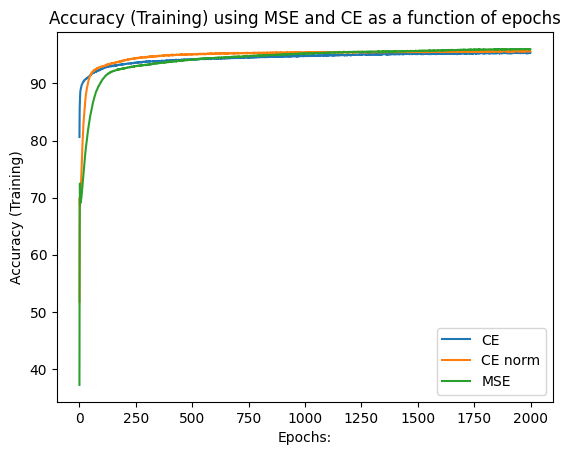

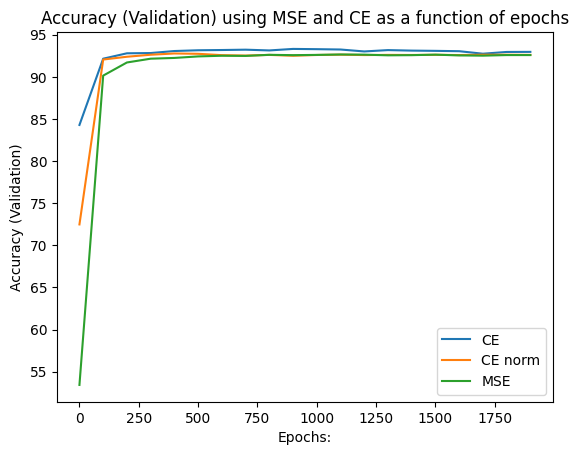

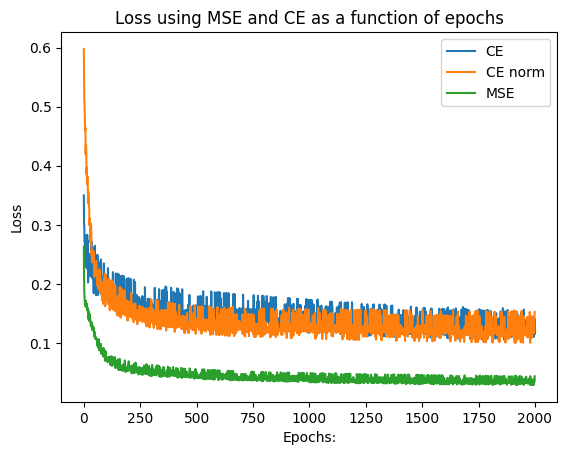

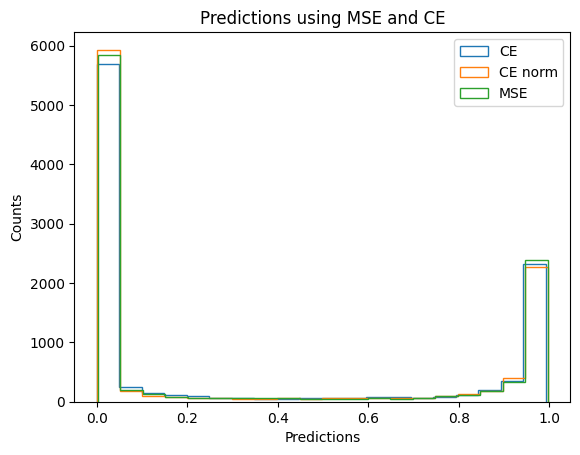

In [13]:
plt.plot(Train_res_CE[1], label='CE')
plt.plot(Train_res_CE_norm[1], label='CE norm')
plt.plot(Train_res_MSE[1], label='MSE')
plt.ylabel('Accuracy (Training)')
plt.xlabel("Epochs:")
plt.title('Accuracy (Training) using MSE and CE as a function of epochs')
plt.legend()
plt.show()

plt.plot(np.arange(0, 2000, 100), Train_res_CE[5], label='CE')
plt.plot(np.arange(0, 2000, 100), Train_res_CE_norm[5], label='CE norm')
plt.plot(np.arange(0, 2000, 100),Train_res_MSE[5], label='MSE')
plt.ylabel('Accuracy (Validation)')
plt.xlabel("Epochs:")
plt.title('Accuracy (Validation) using MSE and CE as a function of epochs')
plt.legend()
plt.show()

plt.plot(Train_res_CE[0], label='CE')
plt.plot(Train_res_CE_norm[0], label='CE norm')
plt.plot(Train_res_MSE[0], label='MSE')
plt.ylabel('Loss')
plt.xlabel("Epochs:")
plt.title('Loss using MSE and CE as a function of epochs')
plt.legend()
plt.show()

plt.hist(Val_res_CE[3], histtype='step', bins=20, label='CE')
plt.hist(Val_res_CE_norm[3], histtype='step', bins=20, label='CE norm')
plt.hist(Val_res_MSE[3], histtype='step', bins=20, label='MSE')
plt.xlabel("Predictions")
plt.ylabel("Counts")
plt.title('Predictions using MSE and CE')
plt.legend()
plt.show()

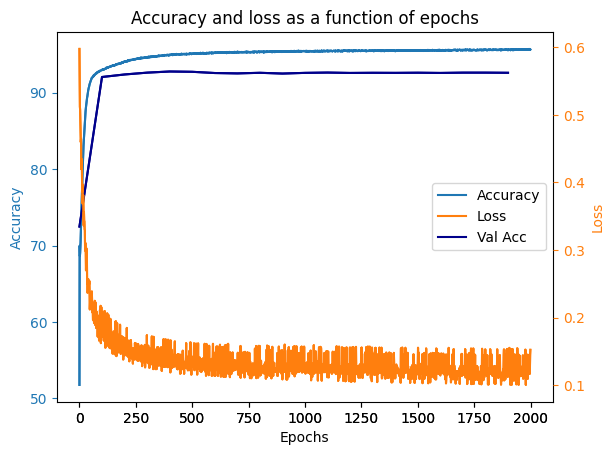

In [16]:
fig=plt.figure()
ax1=fig.add_subplot(111, label='Accuracy')
ax2=fig.add_subplot(111, label='Loss', frame_on=False)

ax1.set_title('Accuracy and loss as a function of epochs')

ax1.plot(Train_res_CE_norm[1], color="C0")
ax1.plot(np.arange(0, 2000, 100), Train_res_CE_norm[5], color = 'darkblue')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy', color="C0")
ax1.tick_params(axis='y', colors="C0")

ax2.plot(Train_res_CE_norm[0], color="C1") 
ax2.set_ylabel('Loss', color="C1")       
ax2.yaxis.set_label_position('right') 
ax2.yaxis.tick_right()
ax2.tick_params(axis='y', colors="C1")

l1,=ax1.plot(Train_res_CE_norm[1], color="C0")
l2,=ax2.plot(Train_res_CE_norm[0], color="C1")
l3,=ax1.plot(np.arange(0, 2000, 100), Train_res_CE_norm[5], color = 'darkblue')
plt.legend([l1, l2, l3], ["Accuracy", "Loss", "Val Acc"], loc = "center right")

plt.show()

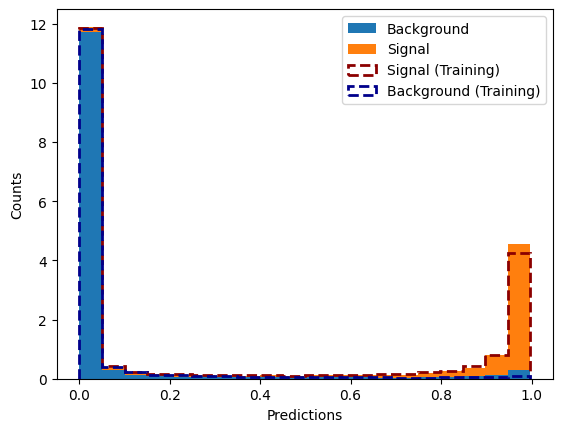

In [17]:
Pred_back: Sequence = []
Pred_sig: Sequence = []

# Separate signal and background events
for i in range(0, len(Val_res_CE_norm[2])):
    if Val_res_CE_norm[2][i] == 0:
        Pred_back.append(Val_res_CE_norm[3][i][0])
    else:
        Pred_sig.append(Val_res_CE_norm[3][i][0])

Pred_back_arr = np.array(Pred_back)
Pred_sig_arr = np.array(Pred_sig)

Pred_back_t: Sequence = []
Pred_sig_t: Sequence = []

# Separate signal and background events (train)
for i in range(0, len(Train_res_CE_norm[2])):
    if Train_res_CE_norm[2][i] == 0:
        Pred_back_t.append(Train_res_CE_norm[3][i][0])
    else:
        Pred_sig_t.append(Train_res_CE_norm[3][i][0])

Pred_back_t_arr = np.array(Pred_back_t)
Pred_sig_t_arr = np.array(Pred_sig_t)

plt.hist([Pred_back_arr, Pred_sig_arr], histtype='bar', stacked=True, bins=20, label=['Background', 'Signal'], density=True)
plt.hist([Pred_back_t_arr, Pred_sig_t_arr], lw = 2, ls = '--', histtype='step', stacked=True, bins=20, color=['darkblue', 'darkred'], label=['Background (Training)', 'Signal (Training)'], density=True)
plt.xlabel("Predictions")
plt.ylabel("Counts")
plt.legend()
plt.show()

### Ploting the signal against background distribution for specific input variables

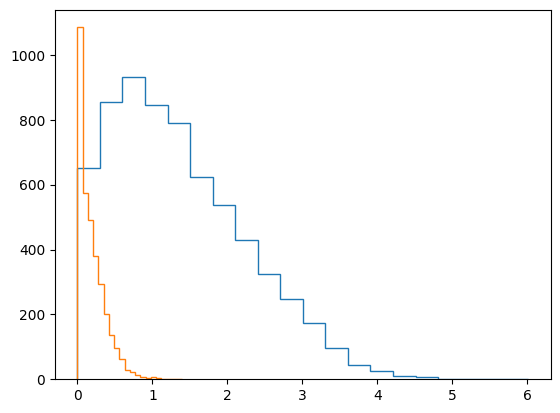

In [18]:
In_back: Sequence = []
In_sig: Sequence = []


# Separate signal and background events
for i in range(0, len(Val_res_CE[3])):
    if np.round(Val_res_CE[3][i]) == 0:
        In_back.append(Val_res_CE[4][i])
    else:
        In_sig.append(Val_res_CE[4][i])

In_back_arr = np.array(In_back)
In_sig_arr = np.array(In_sig)

plt.hist(In_back_arr[:, 0], histtype='step', bins=20)
plt.hist(In_sig_arr[:, 0], histtype='step', bins=20)
plt.show()

### Final test accuracy

In [19]:
Acc_tot: Sequence = []
Acc_back_tot: Sequence = []
Acc_sig_tot: Sequence =[]
Loss_tot: Sequence = []
Pred_tot: Sequence = []

# Compute the accuracy for different random initializations
for N in range(10):

    net = NeuralNet([
        Linear(input_size=12, output_size=9, Seed=False),
        Activation(tanh, tanh_prime),
        Linear(input_size=9, output_size=3, Seed=False),
        Activation(tanh, tanh_prime),
        Linear(input_size=3, output_size=9, Seed=False),
        Activation(tanh, tanh_prime),
        Linear(input_size=9, output_size=1, Seed=False),
        Activation(sigmoid, sigmoid_prime),
    ])

    Train_res: Tuple = net.train(inputs=norm_dataset1_train, targets=bin_labels_train,
                                       val_inputs=norm_dataset1_val, val_targets=bin_labels_val,
                                       loss=BinCrossEntropy(), iterator=BatchIterator(batch_size=batch_num), num_epochs=1000, Print=False)

    Test_res: Tuple = net.validate(inputs=norm_dataset1_test, targets=bin_labels_test,
                                            loss=BinCrossEntropy(), iterator=BatchIterator(batch_size=batch_num))
    
    Actual_back: Sequence = []
    Pred_back: Sequence = []
    Actual_sig: Sequence = []
    Pred_sig: Sequence = []

    # Separate signal and background events
    for i in range(0, len(Test_res[2])):
        if Test_res[2][i] == 0:
            Actual_back.append(Test_res[2][i])
            Pred_back.append(Test_res[3][i])
        else:
            Actual_sig.append(Test_res[2][i])
            Pred_sig.append(Test_res[3][i])

    Actual_back_arr = np.array(Actual_back)
    Pred_back_arr = np.array(Pred_back)
    Actual_sig_arr = np.array(Actual_sig)
    Pred_sig_arr = np.array(Pred_sig)

    # Compute accuracy for signal and background
    Acc_back = np.mean(Pred_back_arr.round()==Actual_back_arr) * 100
    Acc_sig = np.mean(Pred_sig_arr.round()==Actual_sig_arr) * 100
    
    Acc_tot.append(Test_res[1])
    Acc_back_tot.append(Acc_back)
    Acc_sig_tot.append(Acc_sig)
    Loss_tot.append(Test_res[0])
    Pred_tot.append(Test_res[3])

    # Print accuracies for each iteration
    print("Acc = ", Test_res[1], "Acc_back = ", Acc_back, "Acc_sig = ", Acc_sig)


Acc_back_arr = np.array(Acc_back_tot)
Acc_sig_arr = np.array(Acc_sig_tot)
Acc_array = np.array(Acc_tot)

# Compute the final accuracies as the mean on the iterations
Acc_final = np.mean(Acc_array)
Acc_back_final = np.mean(Acc_back_arr)
Acc_sig_final = np.mean(Acc_sig_arr)

print("Final mean Acc = ", Acc_final,", back mean Acc = ", Acc_back_final,", sig mean Acc = ", Acc_sig_final, ", Article Acc = ", Acc_article)

Acc =  92.61 Acc_back =  92.54172204991877 Acc_sig =  92.75317435738619
Acc =  87.96000000000001 Acc_back =  98.33111800324914 Acc_sig =  66.21244967482193
Acc =  91.8 Acc_back =  96.67700487372618 Acc_sig =  81.57324248993496
Acc =  91.25999999999999 Acc_back =  96.83946241323291 Acc_sig =  79.56023536698669
Acc =  85.57000000000001 Acc_back =  99.06956136464333 Acc_sig =  57.26231031279033
Acc =  92.85 Acc_back =  93.08817013735047 Acc_sig =  92.35057293279652
Acc =  89.95 Acc_back =  97.87328311918476 Acc_sig =  73.33539795602354
Acc =  80.47 Acc_back =  99.60124058484713 Acc_sig =  40.35305048002478
Acc =  82.64 Acc_back =  99.39447644365677 Acc_sig =  47.50696810157944
Acc =  87.62 Acc_back =  98.70033968394624 Acc_sig =  64.38525859399195
Final mean Acc =  88.273 , back mean Acc =  97.21163786737557 , sig mean Acc =  69.52926602663364 , Article Acc =  81.54
